In [18]:
import pandas as pd
import numpy as np
from osgeo import gdal
from osgeo import gdal_array
from osgeo import osr
import matplotlib.pylab as plt
from pylab import figure, cm
from matplotlib.colors import LogNorm
import matplotlib
matplotlib.rcParams['figure.figsize'] = [12, 6]

In [3]:
gecon = pd.read_excel('Gecon40_post_final.xls') # Required xlutils, `pip3 install xlutils`
gecon.head().T

,0,1,2,3,4
AREA,0,10.4777,33.623,12.1534,36.4603
COUNTRY,Bosnia&Herzegovina,Brazil,Brazil,Brazil,Brazil
D1,0,252.85,639.833,565.792,604.486
D2,0,181.754,109.199,565.792,604.486
D3,0,168.666,109.199,522.757,547.912
D4,0,156.602,109.199,522.757,547.912
DIS_LAKE,NaN,156602,580072,630610,615036
DIS_MAJOR_RIVER,NaN,181754,109199,683544,671246
DIS_OCEAN,NaN,252850,639834,565792,604486
DIS_RIVER,NaN,168666,188349,522757,547912


# Visualizing as a map, and exporting to .tiff format for GIS 

In [26]:
# The lattitue and Longitude values, as well as the extent
lat = gecon.LAT
lon = gecon.LONGITUDE
xmin,ymin,xmax,ymax = [lon.min(),lat.min(),lon.max(),lat.max()]
xmin,ymin,xmax,ymax

(-180, -89, 179, 83)

In [27]:
# The 'resolution' of our output raster. 1 degree each way, since that's how the data is presented.
xres = 1
yres = 1

In [28]:
ncols = 360
nrows = 173

In [29]:
geotransform=(xmin,xres,0,ymax,0, -yres) # Setting values for transform

In [30]:
values = gecon.MER1990_40 # Just picking one column for now - the Gross cell product, 1990

In [31]:
array = np.full(nrows*ncols, np.nan) # A 'balnk' image - we'll set the values based on the lat and lon columns

In [32]:
array[(83-lat)*ncols+(lon+180)] = values

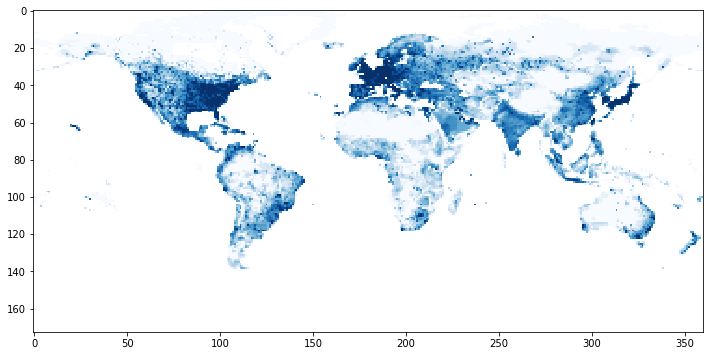

In [33]:
plt.imshow(array.reshape(nrows, ncols), cmap=cm.Blues, norm=LogNorm(vmin=0.01, vmax=8))
plt.savefig('Gecon_blues.png')

In [35]:
# Saving as a raster (code from stackoverflow)

output_raster = gdal.GetDriverByName('GTiff').Create('gecon_GCP1990.tif', ncols, nrows, 1 ,gdal.GDT_Float32)  # Open the file
output_raster.SetGeoTransform(geotransform)  
srs = osr.SpatialReference()                 
srs.ImportFromEPSG(4326) # WGS84
output_raster.SetProjection( srs.ExportToWkt() )
                                                   
output_raster.GetRasterBand(1).WriteArray(array.reshape(nrows, ncols))   # Writes my array to the raster
output_raster.FlushCache()
output_raster = None # This is important - without it the result is a blank raster image.